In [1]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 189 kB 7.2 MB/s 
     |████████████████████████████████| 56 kB 2.8 MB/s 


In [2]:
from fastai.text.all import *

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
! cp -r "/content/drive/My Drive/NLP_Project/data/ruddit_with_text.csv" .
# ! cp -r "/content/drive/My Drive/NLP_Project/data/jigsaw1_use_balanced_tok.zip" .
# ! mkdir "jigsaw1_use_balanced/models"
# ! cp -r "/content/drive/My Drive/NLP_Project/data/models/acc88_6.pth" "jigsaw1_use_balanced/models"
# ! unzip jigsaw1_use_balanced.zip
# ! unzip jigsaw1_use_balanced_tok.zip

# ! cp -r "/content/drive/My Drive/NLP_Project/data/jigsaw3.zip" .
# ! unzip jigsaw3.zip

In [19]:

# def interval(score, bins=5):
#     scale = bins/2
#     return int((score+1)*scale)

def interval(score, bins=[0.6,0.8,1.,1.2,2.]):
    for i, bound in enumerate(bins):
        if (score+1)<bound:
            ret = i
            break
    return ret

df =  pd.read_csv("ruddit_with_text.csv")
df['label'] = df['offensiveness_score'].apply(interval)
dls = TextDataLoaders.from_df(df, text_col='txt', label_col='label', valid_pct=0.2, seed=0)
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


SuggestedLRs(valley=3.630780702224001e-05)

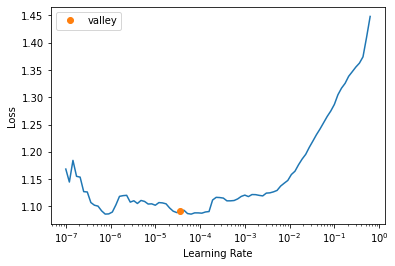

In [26]:
learn.unfreeze()
learn.lr_find()

In [21]:
learn.fine_tune(4, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.583758,1.485721,0.348758,00:08


epoch,train_loss,valid_loss,accuracy,time
0,1.446737,1.367473,0.403599,00:10
1,1.397468,1.335048,0.377892,00:09
2,1.277810,1.295922,0.423308,00:10
3,1.180328,1.289279,0.417309,00:09


In [23]:
learn.fine_tune(4, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.125124,1.292402,0.419023,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.122581,1.287249,0.428449,00:09
1,1.124554,1.285116,0.423308,00:09
2,1.122165,1.286480,0.425021,00:09
3,1.105430,1.289287,0.427592,00:10


In [27]:
learn.unfreeze()
learn.fit_one_cycle(8, 3e-5)

epoch,train_loss,valid_loss,accuracy,time
0,1.121688,1.283801,0.423308,00:09
1,1.102602,1.279455,0.436161,00:09
2,1.107373,1.280633,0.422451,00:09
3,1.085875,1.274702,0.434447,00:09
4,1.072212,1.272936,0.427592,00:09
5,1.061388,1.280914,0.432734,00:09
6,1.060035,1.278859,0.430163,00:09
7,1.046118,1.275431,0.431020,00:09


In [13]:
modelname = "bins5_acc62"
learn.save(modelname)
! cp -r models/{modelname}.pth "/content/drive/My Drive/NLP_Project/data/models/" 
# pickle.dump(dls.vocab, open("jigsaw1_lm.pickle", 'wb'))

In [ ]:
# ! zip -r jigsaw1_use_balanced_tok.zip jigsaw1_use_balanced_tok
# ! cp jigsaw1_use_balanced_tok.zip "/content/drive/My Drive/NLP_Project/data/"
# ! cp jigsaw1_lm.pickle "/content/drive/My Drive/NLP_Project/data/"
# ! cp -r "jigsaw1_use_balanced/models/acc88_6.pth" "/content/drive/My Drive/NLP_Project/data/models/"

In [28]:
learn.predict("this is good")

('0', TensorText(0), TensorText([0.6040, 0.3684, 0.0117, 0.0013, 0.0146]))

In [14]:
! cp -r "/content/drive/My Drive/NLP_Project/data/jigsaw3.zip" .
! unzip jigsaw3.zip

Archive:  jigsaw3.zip
  inflating: comments_to_score.csv   
  inflating: sample_submission.csv   
  inflating: validation_data.csv     


# Batch Inference 

In [ ]:
from tqdm import tqdm

test_data =  pd.read_csv("comments_to_score.csv")
comments_list = []
id_list = []
for index, row in tqdm(test_data.iterrows()):
  id_list.append(row['comment_id'])
  comments_list.append(row['text'])

test_dl = dls.test_dl(comments_list)
preds = learn.get_preds(dl=test_dl)

scores = preds[0].cpu().numpy()[:,1]
outfile = open("submission.csv",'w')
outfile.write("{},{}\n".format("comment_id", "score"))

for i in range(len(scores)):
  outfile.write("{},{}\n".format(id_list[i], scores[i]))
outfile.close() 


7537it [00:00, 13287.76it/s]


# Validation

In [15]:
from tqdm import tqdm
valid_data =  pd.read_csv("validation_data.csv")
less_toxic = []
more_toxic = []
for index, row in tqdm(valid_data.iterrows()):
  less_toxic.append(row['less_toxic'])
  more_toxic.append(row['more_toxic'])
all_comments = less_toxic+more_toxic

30108it [00:02, 12430.32it/s]


In [28]:
# Inference
# test_dl = dls.test_dl(all_comments)
preds = learn.get_preds(dl=test_dl)

In [29]:
 # Score
rawpreds = preds[0].cpu().numpy()
args = np.argmax(preds[0].cpu().numpy(),axis=1)
slicedpreds = rawpreds[np.arange(rawpreds.shape[0]),args]
scores = args+(slicedpreds)
# scores = preds[0].cpu().numpy()[:,1]
less, more = np.split(scores, 2)
validation_score = (less<more).sum()/len(less)

 # Score random
np.random.seed(1)
scores = np.random.rand(valid_data.count()[0])
less, more = np.split(scores, 2)
validation_score_random = (less<more).sum()/len(less)

print("Validation score: {}\nValidation score random: {}".format(validation_score, validation_score_random))

Validation score: 0.6313936495283645
Validation score random: 0.500464992692972
